# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts.

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input.

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1.


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K.

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [ ]:
def image_generator(files, batch_size = 32, sz = (256, 256)):

  while True:

    #extract a random batch
    batch = np.random.choice(files, size = batch_size)

    #variables for collecting batches of inputs and outputs
    batch_x = []
    batch_y = []


    for f in batch:

        #get the masks. Note that masks are png files
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask
        mask[mask >= 2] = 0
        mask[mask != 0 ] = 1

        batch_y.append(mask)

        #preprocess the raw images
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)


In [ ]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [ ]:
x, y= next(train_generator)

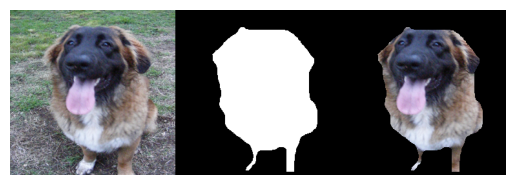

In [ ]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = tf.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    # Explicitly cast the boolean tensor to float32 before summing
    inter = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)), 'float32'))
    # Cast yt0 to float32 to match the data type of yp0
    union = tf.reduce_sum(tf.add(tf.cast(yt0, 'float32'), yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x

  #down sampling
  f = 8
  layers = []

  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64

  #bottleneck
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1

  #upsampling
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1


  #classification
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  #model creation
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])

  return model

In [ ]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.weights.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))

        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        #predict the mask
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1
        msk[msk < 0.5] = 0

        #show the mask and the segmented image
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_184']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


i= 1 loss= 0.5858926773071289 val_loss= 0.5615532994270325 mean_iou= 1.2886944205092732e-05 val_mean_iou= 0.0


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_184']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


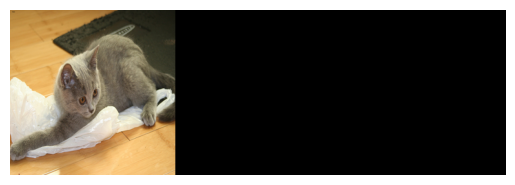

i= 2 loss= 0.5107489228248596 val_loss= 0.49190279841423035 mean_iou= 0.11946424096822739 val_mean_iou= 0.31267860531806946
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


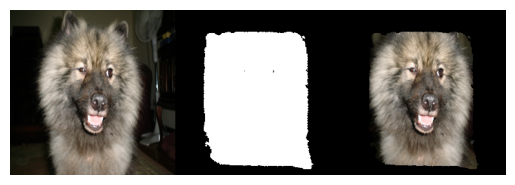

i= 3 loss= 0.4483789801597595 val_loss= 0.4407009184360504 mean_iou= 0.2978944778442383 val_mean_iou= 0.3165352940559387
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


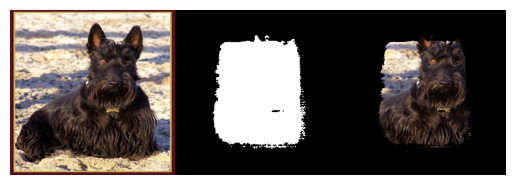

i= 4 loss= 0.4323279559612274 val_loss= 0.41921138763427734 mean_iou= 0.3142920732498169 val_mean_iou= 0.335430383682251
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


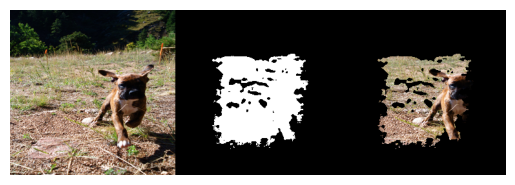

i= 5 loss= 0.40734633803367615 val_loss= 0.4054248631000519 mean_iou= 0.32991352677345276 val_mean_iou= 0.29641324281692505
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


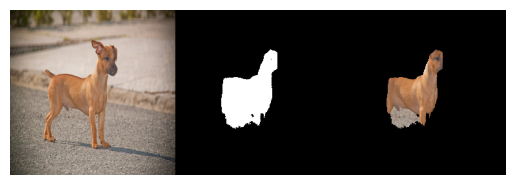

i= 6 loss= 0.3760582506656647 val_loss= 0.3202240467071533 mean_iou= 0.34910300374031067 val_mean_iou= 0.36852988600730896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


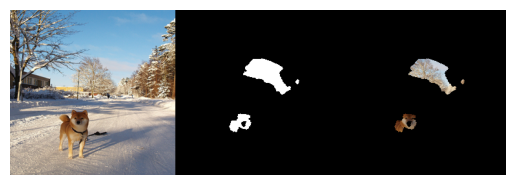

i= 7 loss= 0.34228286147117615 val_loss= 0.3305932581424713 mean_iou= 0.36774709820747375 val_mean_iou= 0.38448670506477356
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


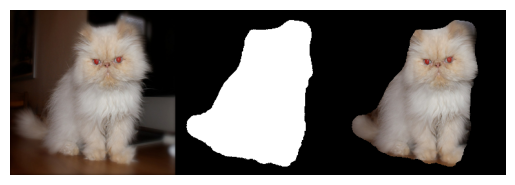

i= 8 loss= 0.3157428205013275 val_loss= 0.319675475358963 mean_iou= 0.38395798206329346 val_mean_iou= 0.37839147448539734
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


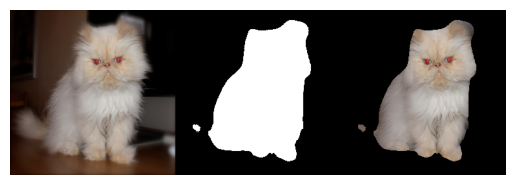

i= 9 loss= 0.29218605160713196 val_loss= 0.2641304135322571 mean_iou= 0.39321038126945496 val_mean_iou= 0.4084121584892273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


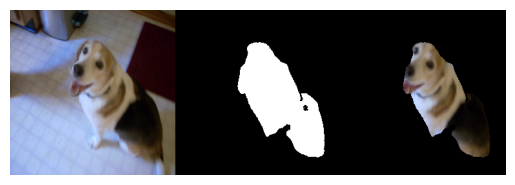

i= 10 loss= 0.26922640204429626 val_loss= 0.2601654529571533 mean_iou= 0.4045310914516449 val_mean_iou= 0.40308502316474915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


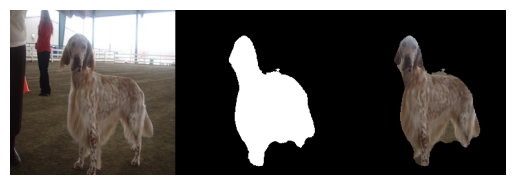

i= 11 loss= 0.24788694083690643 val_loss= 0.26695704460144043 mean_iou= 0.4116407632827759 val_mean_iou= 0.41487738490104675
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


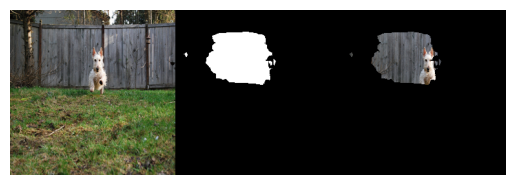

i= 12 loss= 0.2443753480911255 val_loss= 0.229773610830307 mean_iou= 0.4158141314983368 val_mean_iou= 0.42514723539352417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


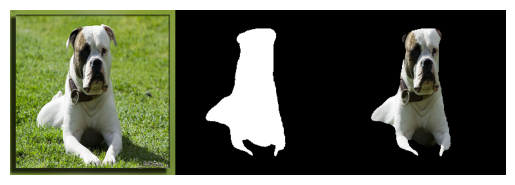

i= 13 loss= 0.2290233075618744 val_loss= 0.22961196303367615 mean_iou= 0.41999882459640503 val_mean_iou= 0.4142899513244629
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


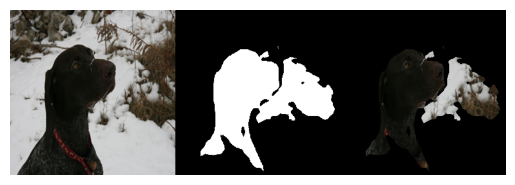

i= 14 loss= 0.21305139362812042 val_loss= 0.2297080159187317 mean_iou= 0.4262895882129669 val_mean_iou= 0.4176445007324219
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


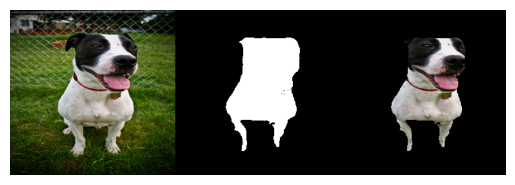

i= 15 loss= 0.20774126052856445 val_loss= 0.26071155071258545 mean_iou= 0.42822739481925964 val_mean_iou= 0.41814854741096497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


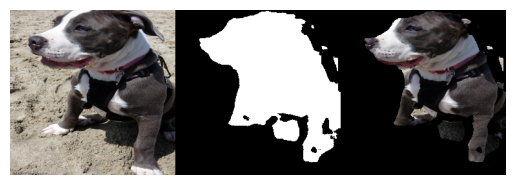

i= 16 loss= 0.19569016993045807 val_loss= 0.19760733842849731 mean_iou= 0.4335028827190399 val_mean_iou= 0.4239073097705841
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


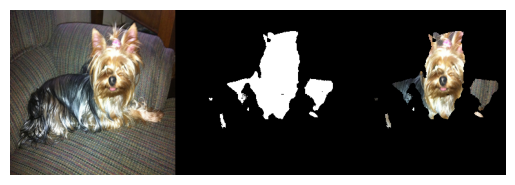

i= 17 loss= 0.1846207082271576 val_loss= 0.19806748628616333 mean_iou= 0.4367082417011261 val_mean_iou= 0.428396612405777
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


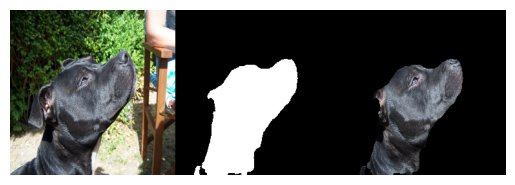

i= 18 loss= 0.1755274087190628 val_loss= 0.21105533838272095 mean_iou= 0.4402676820755005 val_mean_iou= 0.4288282096385956
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


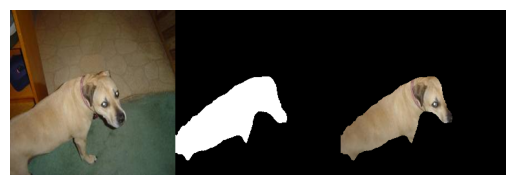

i= 19 loss= 0.1680116206407547 val_loss= 0.21007052063941956 mean_iou= 0.44229453802108765 val_mean_iou= 0.4314373731613159
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


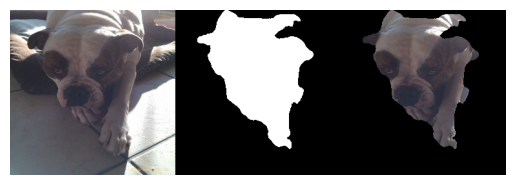

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit(train_generator,
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

In [ ]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

#show the mask and the segmented image
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

